#### Tutorial adapted from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

#### Install reqs

In [2]:
# !pip install hyper-nn
# !pip install tqdm
# !pip install tensorboard
# !pip install matplotlib

#### Name dataset

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('./names/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Portuguese', 'Czech', 'Korean', 'Arabic', 'English', 'Russian', 'German', 'Spanish', 'Vietnamese', 'Polish', 'Irish', 'Japanese', 'French', 'Scottish', 'Greek', 'Chinese', 'Italian', 'Dutch']
O'Neal


In [4]:
import torch
import torch.nn as nn

class TargetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TargetRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = nn.GRUCell(n_categories + input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, 256)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, inp, hidden):
        concatenated = torch.cat((category, inp), dim=-1)
        hidden =  self.rnn(concatenated, hidden)

        output = self.linear(hidden)
        output = torch.relu(output)
        output = self.linear2(output)
        output = torch.relu(output)
        output = self.linear3(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [5]:
target_network = TargetRNN(n_letters, 128, n_letters)
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

193467

#### Dynamic Hypernetwork that modifies its weights based on network inputs

In [14]:
import torch.nn as nn
from typing import Optional, Iterable, Dict, Any, Tuple
from hypernn.torch.dynamic_hypernet import TorchDynamicHyperNetwork

class CharDynamicHyperNetwork(TorchDynamicHyperNetwork):
    def __init__(
        self,
        input_dim: int,
        target_network: nn.Module,
        *args,
        **kwargs
    ):
        super().__init__(
            input_dim,
            target_network,
            *args,
            **kwargs
        )

    def generate_params(
        self, category_tensor, input_tensor, hidden_state: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:
        concatenated = torch.cat((category_tensor, input_tensor), dim=-1)
        embedding, hidden_state = self.embedding_module(concatenated, hidden_state=hidden_state)
        generated_params = self.weight_generator(embedding).view(-1)
        return generated_params, {"embedding": embedding, "hidden_state": hidden_state}


In [15]:
EMBEDDING_DIM = 4
NUM_EMBEDDINGS = 64


hypernetwork = CharDynamicHyperNetwork.from_target(
    target_network,
    embedding_dim=EMBEDDING_DIM,
    num_embeddings=NUM_EMBEDDINGS,
    input_dim=n_letters+n_categories
)
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

24523

In [16]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

#### Training procedure

In [17]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
import tqdm

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer


In [18]:
import torch.nn as nn


def train_dynamic_hyper_rnn_step(dynamic_hyper_rnn, optimizer, category_tensor, input_line_tensor, target_line_tensor):
    criterion = nn.NLLLoss()

    target_line_tensor = target_line_tensor.unsqueeze(-1).to(dynamic_hyper_rnn.device)
    hidden = target_network.initHidden().to(dynamic_hyper_rnn.device)
    hyper_hidden = dynamic_hyper_rnn.embedding_module.init_hidden()

    optimizer.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        out, _, aux_output = dynamic_hyper_rnn(
            category_tensor.to(dynamic_hyper_rnn.device),
            input_line_tensor[i].to(dynamic_hyper_rnn.device),
            hidden,
            generate_params_kwargs={
                "category_tensor":category_tensor.to(dynamic_hyper_rnn.device),
                "input_tensor":input_line_tensor[i].to(dynamic_hyper_rnn.device),
                "hidden_state":hyper_hidden
            },
            has_aux=True
        )
        hyper_hidden = aux_output["hidden_state"]
        output, hidden = out
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    torch.nn.utils.clip_grad_norm_(dynamic_hyper_rnn.parameters(), 10.0)
    optimizer.step()

    grad_dict = {}
    for n, W in dynamic_hyper_rnn.named_parameters():
        if W.grad is not None:
            grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, {"loss":loss.item() / input_line_tensor.size(0), **grad_dict}

In [19]:
from tqdm import tqdm
import numpy as np
import time
import datetime as dt


def train(hypernet, lr, n_iters):
    writer = get_tensorboard_logger("TorchHyperRNN")
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)
    bar = tqdm(np.arange(n_iters))

    for i in bar:
        category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()

        start_time = dt.datetime.today().timestamp()

        _, metrics = train_dynamic_hyper_rnn_step(hypernet, optimizer, category_tensor, input_line_tensor, target_line_tensor)

        time_diff = (dt.datetime.today().timestamp() - start_time) + 1e-5

        metrics["diff"] = time_diff
        for key in metrics:
            writer.add_scalar(key, metrics[key], i)


        loss = metrics['loss']
        bar.set_description('Loss: {} Iters p sec: {}'.format(loss, str(time_diff)))


In [20]:
learning_rate = 0.0001

train(hypernet=hypernetwork, lr=learning_rate, n_iters=50000)

Follow tensorboard logs with: python -m tensorboard.main --logdir '/home/shyam/Code/hyper-nn/notebooks/dynamic_hypernetworks/tensorboard_logs/TorchHyperRNN_2023-01-17 12:47:14.421052'


Loss: 3.6569724082946777 Iters p sec: 0.030779824981689453:  16%|█▌        | 7777/50000 [03:11<17:19, 40.63it/s] 


KeyboardInterrupt: 

In [21]:
hypernetwork = hypernetwork.to(torch.device('cpu'))

In [22]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = target_network.initHidden()
        hyper_hidden = hypernetwork.embedding_module.init_hidden()

        output_name = start_letter

        hidden_states = []
        for i in range(max_length):
            out, _, aux_output = hypernetwork(
                category_tensor,
                input[0],
                hidden,
                generate_params_kwargs={
                    "category_tensor":category_tensor,
                    "input_tensor":input[0],
                    "hidden_state":hyper_hidden
                },
                has_aux=True
            )
            hyper_hidden = aux_output["hidden_state"]
            output, hidden = out
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Ronr
Uaaaab
Sanat
Gor
Eosr
Rosri
Siru
Pale
Aiei
Cha
Hau
Iit


In [27]:
with torch.no_grad():  # no need to track history in sampling
    category_tensor = categoryTensor("German")
    input = inputTensor("G")
    hidden = target_network.initHidden()
    hyper_hidden = hypernetwork.embedding_module.init_hidden()

    output_name = "G"

    hidden_states = []
    for i in range(max_length):
        out, _, aux_output = hypernetwork(
                category_tensor,
                input[0],
                hidden,
                generate_params_kwargs={
                    "category_tensor":category_tensor,
                    "input_tensor":input[0],
                    "hidden_state":hyper_hidden
                },
                has_aux=True
            )
        hyper_hidden = aux_output["hidden_state"]
        hidden_states.append(hyper_hidden)
        output, hidden = out
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = inputTensor(letter)
    print(output_name)

Gor


In [28]:
hidden_state_images = [((h - h.min()) / (h.max() - h.min())).detach().cpu().numpy() for h in hidden_states]

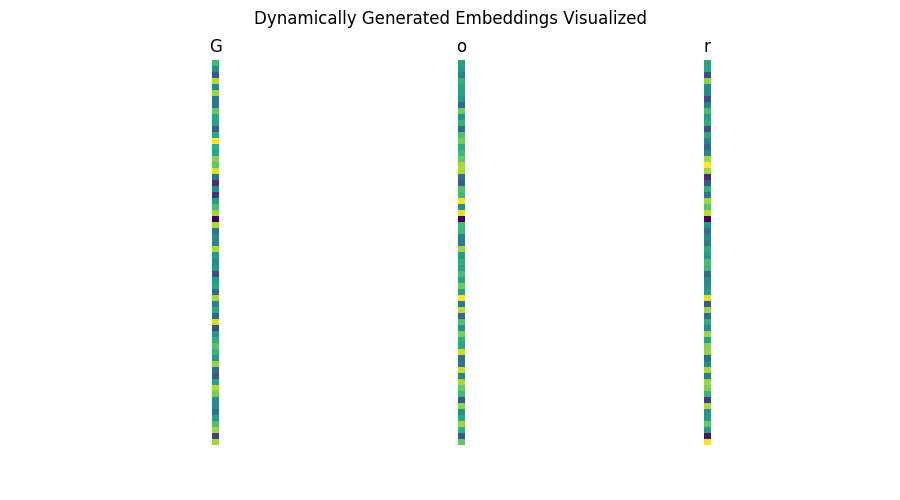

In [29]:
import matplotlib.pyplot as plt
%matplotlib ipympl
f,axs=plt.subplots(1,len(hidden_state_images),figsize=(9,5)) #ROW,COLUMN
f.suptitle("Dynamically Generated Embeddings Visualized")
# f.tight_layout() # Or equivalently,  "plt.tight_layout()"

for i in range(len(hidden_state_images)):
    img = hidden_state_images[i].reshape(64,1,1)
    letter = output_name[i]
    ax = axs[i]
    ax.grid(False)
    ax.axis('off')
    ax.title.set_text(letter)
    ax.imshow(img)
    f.subplots_adjust(wspace=None, hspace=None)
